In [1]:
BASE_DIR = "/tmp/akshett.jindal"

In [2]:
MODEL_IDS = [
    "google/vit-huge-patch14-224-in21k",
    "Salesforce/instructblip-vicuna-13b",
    "HuggingFaceM4/idefics-9b-instruct",
    "llava-hf/llava-1.5-13b-hf",
    "MAGAer13/mplug-owl-llama-7b",
    "openflamingo/OpenFlamingo-9B-vitl-mpt7b",
]
SUBJECTS = [1, 2, 5, 7]
PROMPT_NUMBER = 1

In [3]:
ROIS = [
    "HCP_MMP1",
    "floc-bodies",
    "floc-faces",
    "floc-places",
    "floc-words",
    "prf-eccrois",
    "prf-visualrois",
]
METRICS = ["r2", "pearson"]

In [4]:
import os.path
import pandas
import pickle

rows = []

for model_id in MODEL_IDS:

    for subject in SUBJECTS:
        model_name = model_id.replace("/", "_").replace(" ", "_")

        scores_dir = os.path.join(BASE_DIR, "final_scores", f"prompt_{PROMPT_NUMBER}", model_name, f"subj{subject:02}")

        # trn_scores_filepath = os.path.join(scores_dir, "training.pkl")
        val_scores_filepath = os.path.join(scores_dir, "validation.pkl")

        # with open(trn_scores_filepath, "rb") as f:
        #     trn_scores = pickle.load(f)
        with open(val_scores_filepath, "rb") as f:
            val_scores = pickle.load(f)

        # for hs_name, hs_scores in trn_scores.items():
        #     print(tabulate_scores(hs_name, hs_scores, False))
        #     print(f"MODEL='{model_id}' => {hs_name}, SUBJECT={subject}")
        #     print()

        for hs_name, hs_scores in val_scores.items():
            for roi in ROIS:
                row = {
                    "model_id": model_id,
                    "subject": subject,
                    "hidden_state_name": hs_name,
                    "roi": roi,
                }
                for metric in METRICS:
                    row[metric] = hs_scores[metric][roi]
                    # print(f"{metric = }, {row[metric] = }")

                rows.append(row)

df_data = {
    key: [r[key] for r in rows]
    for key in rows[0].keys()
}

df = pandas.DataFrame(data=df_data)
df

,model_id,subject,hidden_state_name,roi,r2,pearson
0,google/vit-huge-patch14-224-in21k,1,hidden_states,HCP_MMP1,0.056795,0.150690
1,google/vit-huge-patch14-224-in21k,1,hidden_states,floc-bodies,0.127339,0.286457
2,google/vit-huge-patch14-224-in21k,1,hidden_states,floc-faces,0.068811,0.231604
3,google/vit-huge-patch14-224-in21k,1,hidden_states,floc-places,0.115491,0.305894
4,google/vit-huge-patch14-224-in21k,1,hidden_states,floc-words,0.049376,0.200116
...,...,...,...,...,...,...
219,openflamingo/OpenFlamingo-9B-vitl-mpt7b,7,hidden_states,floc-faces,0.083737,0.271536
220,openflamingo/OpenFlamingo-9B-vitl-mpt7b,7,hidden_states,floc-places,0.105720,0.334394
221,openflamingo/OpenFlamingo-9B-vitl-mpt7b,7,hidden_states,floc-words,0.036584,0.186436
222,openflamingo/OpenFlamingo-9B-vitl-mpt7b,7,hidden_states,prf-eccrois,0.011300,0.117465


In [5]:
import numpy as np

np.isnan(df[(df["model_id"] == "Salesforce/instructblip-vicuna-13b") & (df["roi"] == "floc-places") & (df["subject"] == 1) & (df["hidden_state_name"] == "qformer_hidden_states")]["r2"].values[0])

False

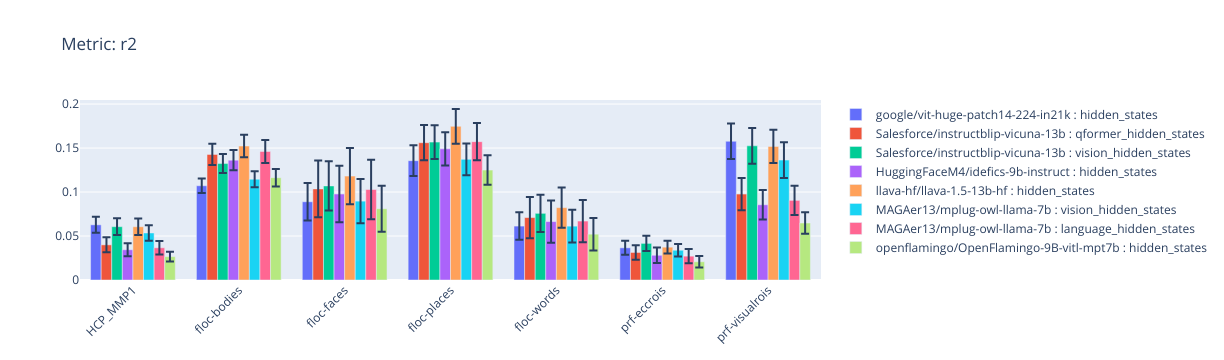

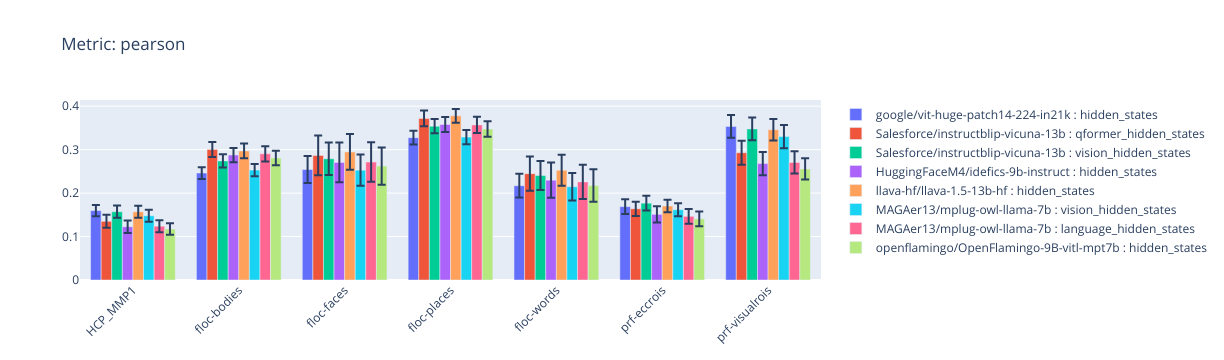

In [7]:
import numpy as np
import plotly.graph_objects as go
import scipy

for metric in METRICS:

    fig = go.Figure()

    for model_id in MODEL_IDS:
        hs_types = df[df["model_id"] == model_id]["hidden_state_name"].unique()
        # roi_maxes = {roi: -1 for roi in ROIS}
        # roi_mins = {roi: 1 for roi in ROIS}
        for hs_type in hs_types:
            roi_scores = {roi: [] for roi in ROIS}
            for subject in SUBJECTS:
                for roi in ROIS:
                    subject_roi_score = df[
                        (df["model_id"] == model_id) &
                        (df["roi"] == roi) &
                        (df["subject"] == subject) &
                        (df["hidden_state_name"] == hs_type)
                    ][metric].values[0]

                    # if np.isnan(subject_roi_score):
                    #     subject_roi_score = 0

                    # print(f"{roi_scores[roi] = }")
                    roi_scores[roi].append(subject_roi_score)
                    # roi_maxes[roi] = max(subject_roi_score, roi_maxes[roi])
                    # roi_mins[roi] = min(subject_roi_score, roi_mins[roi])

            error_y = {roi: scipy.stats.sem(roi_scores[roi]) for roi in ROIS}
            for roi, score in roi_scores.items():
                # roi_scores[roi] = sum(roi_scores[roi]) / len(roi_scores[roi])
                roi_scores[roi] = np.nanmean(np.array(roi_scores[roi]))

            # error_y = {roi: 1 for roi in ROIS}
            # for roi in ROIS:
            #     error_y[roi] = scipy.stats.sem()

            fig.add_trace(go.Bar(
                x=ROIS,
                y=[roi_scores[roi] for roi in ROIS],
                name=f"{model_id} : {hs_type}",
                error_y=dict(type="data", array=[error_y[roi] for roi in ROIS])
            ))

    fig.update_layout(barmode="group", xaxis_tickangle=-45, title=f"Metric: {metric}")
    fig.show()